In [13]:
import time
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
from scipy.spatial.distance import cdist
from datetime import date
from numpy import asarray
import seaborn as sns
import math

pd.options.mode.chained_assignment = None  # default='warn'

#Import Datasets
season_df = pd.read_csv('/Users/yushunli/Documents/Data_Science/nfl_player_similarity/data/2013_to_2022_data.csv')
draft_df = pd.read_csv('/Users/yushunli/Documents/Data_Science/nfl_player_similarity/data/1994_to_2022_draftclass.csv')
#Create a Position Rank columns by Season
season_df['Pos_Rank'] = season_df.groupby(['Pos', 'Season'])['Fantasy_Points'].rank(ascending = False, method = 'min')

In [60]:
def euclid_rank(df, target_player, age):
    target = df.loc[df.Player == target_player]
    non = df.loc[df.Player != target_player]
    #Extract Feature Data
    ret_target = target.loc[:, target.columns.str.endswith("_Scaled")]
    ret_non = non.loc[:, target.columns.str.endswith("_Scaled")]
    #Calculate Euclidian Distance
    euclid = cdist(ret_non, ret_target,  'euclid')
    euclid = euclid.round(decimals=2)
    names = non.Player
    string = 'Age_{}'.format(str(age))
    col = [string]
    df = pd.DataFrame(data = euclid, index=names, columns = col)
    return df

def euclid_compare(peer_df, target):
    
    #Create list of Age ranges
    age_range = []
    
    #For Loop to Create Individual Dataframes of all unique ages
    for i in peer_df.Age.unique():
        a = int(i) 
        age_range.append(a)
        name = 'Age_'+str(a)
        vars()[name] = peer_df.loc[peer_df.Age == i]
        #Run euclid rank
        euclid_name = 'euclid_'+str(a)
        vars()[euclid_name] = euclid_rank(df = vars()[name], target_player = target, age = a)
    
    age_range.sort()
    x = min(age_range)
    df_name = 'euclid_' +str(x)
    base_df = vars()[df_name]

    age_range_mod = age_range[1:]
    
    #Join all age dfs
    for i in age_range_mod:
        name = 'euclid_' +str(i)
        base_df = pd.merge(base_df, vars()[name], how = 'inner', on = 'Player')
    #Return Result
    else:
        base_df['Avg'] = round(base_df.mean(axis=1),2)
        return base_df.sort_values(by = 'Avg', ascending = True)
    
def draft_position(output_df, draft_df, target):
    
    name_list = []
    
    for i in output_df.index:
        name_list.append(i)
    
    name_list.append(target)
    #Filter for output players
    peer_draft = draft_df.loc[draft_df.Player.isin(name_list)]
    
    return peer_draft

def draft_similarity(peer_draft, draft_df):
    #Identify the Target Player's draft position
    target_draft = peer_draft.loc[peer_draft.Player == target].iloc[0]
    
    #Calculate the Abs. Pick Difference
    peer_draft.loc[:,'Pick_Diff_Abs'] = abs(peer_draft['Pick'] - target_draft['Pick'])
    peer_draft.loc[:,'Pos_Pick_Diff_Abs'] = abs(peer_draft['Position_Pick'] - target_draft['Position_Pick'])
    peer_draft.loc[:,'Pick_Diff_Weight'] = round(1-peer_draft['Pick_Diff_Abs']/(32*7),2) #Total Picks
    
    #Calculate the average number of players drafted for each position
    agg = draft_df.groupby(by = ['Season', 'Pos'], as_index=False).count()
    agg = agg.groupby('Pos').mean()
    agg['Avg_Players_Drafted'] = round(agg['Player'],0)
    draft_avg = agg['Avg_Players_Drafted']
    
    #Calculate the Positional Pick Difference
    position = peer_draft.Pos.mode()[0]
    Pos_Pick_Num = draft_avg.loc[draft_avg.index == position][0]
    peer_draft.loc[:,'Pos_Pick_Diff_Weight'] = round(1-peer_draft['Pos_Pick_Diff_Abs']/(Pos_Pick_Num),2) #Number of Players in the Position
    peer_draft.loc[:,'Pick_Score'] = round((peer_draft['Pos_Pick_Diff_Weight'] + peer_draft['Pick_Diff_Weight'])/2,2)
    peer_draft.sort_values(by = 'Pick_Score', ascending = False, inplace = True)
    peer_score = peer_draft[['Player', 'Pick_Score']]
    peer_score.set_index('Player', inplace=True)
    return peer_score.applymap(lambda x: max(0, x))

def draft_score_weighting(output_df, peer_score):
    #Weight the Pick Score based on the number of seasons played
    seasons_played = len(output_df.columns)-1

    #Divide Pick Score to Similarity Score - Weighted by the seasons played
    #The longer they've played, the impact the draft similarity has on the result
    peer_score_similarity = round(output_df.div(output_df.join(peer_score)['Pick_Score'], axis=0),2)
    output_df2 = round((output_df*seasons_played + peer_score_similarity)/(seasons_played+1),2)
    output_df2.sort_values(by = 'Avg', ascending = True, inplace = True)
    #output_df2.reset_index(inplace=True)
    return output_df2

In [67]:
target = 'Justin Jefferson'

In [68]:
#Run Similarity Analysis
#st.dataframe(find_peers(season_df = season_df, target = target))

#Run Find Peers Function
df = season_df.copy(deep=True)
target_df = df.loc[df.Player == target]
position = target_df.Pos.iloc[0]  
min_age = target_df.Age.min()
max_age = target_df.Age.max()
peer_df = df.loc[(df.Age >= min_age) & (df.Age <= max_age) & (df.Pos == position)] 

# #Run the Fantasy Points abs. difference function

peer_df = peer_df.drop_duplicates(subset = ['Player', 'Age'], keep='first')
peer_pivot = peer_df.pivot(index = 'Player', columns = 'Age', values = 'Fantasy_Points').dropna(axis=0)

In [69]:
reference_row = peer_pivot.loc[peer_pivot.index == target].iloc[0]
peer_fantasy = round(abs(peer_pivot.sub(reference_row) / reference_row),2)
peer_fantasy.columns = 'Age_' + peer_fantasy.columns.astype(int).astype(str)
peer_fantasy['Avg'] = round(peer_fantasy.mean(axis = 1),2)
peer_fantasy = peer_fantasy.loc[peer_fantasy.index != target]
peer_fantasy.sort_values(by = 'Avg', ascending = True, inplace=True)
peer_fantasy.head(10)

Age,Age_21,Age_22,Age_23,Avg
Player,,,,
Mike Evans,0.06,0.36,0.16,0.19
CeeDee Lamb,0.24,0.30,0.18,0.24
DeAndre Hopkins,0.47,0.29,0.09,0.28
Tee Higgins,0.28,0.34,0.40,0.34
Brandin Cooks,0.50,0.24,0.32,0.35
JuJu SmithSchuster,0.27,0.13,0.69,0.36
Amari Cooper,0.21,0.33,0.56,0.37
Allen Robinson,0.59,0.04,0.47,0.37
DJ Moore,0.43,0.33,0.41,0.39


In [70]:
euclid_df = euclid_compare(peer_df = peer_df, target = target)

#Aggregate and Average the 2 metrics
output_df = (peer_fantasy+euclid_df) / 2
output_df.sort_values(by = 'Avg', ascending=True, inplace=True)
output_df.head(10)

Age,Age_21,Age_22,Age_23,Avg
Player,,,,
CeeDee Lamb,0.295,0.360,0.245,0.300
Mike Evans,0.275,0.425,0.240,0.310
DeAndre Hopkins,0.510,0.305,0.220,0.345
Brandin Cooks,0.595,0.250,0.330,0.390
Tee Higgins,0.320,0.390,0.505,0.405
Amari Cooper,0.295,0.300,0.680,0.425
DJ Moore,0.505,0.335,0.525,0.455
JuJu SmithSchuster,0.330,0.175,0.865,0.455
Allen Robinson,0.655,0.230,0.500,0.465


In [75]:
peer_draft = draft_position(output_df, draft_df, target)
peer_score = draft_similarity(peer_draft, draft_df)
final_output = draft_score_weighting(output_df, peer_score)
final_output.dropna(subset=['Avg'], inplace=True)
final_output = final_output.loc[final_output.Avg < 1]
final_output

Age,Age_21,Age_22,Age_23,Avg
Player,,,,
CeeDee Lamb,0.30,0.36,0.25,0.30
Mike Evans,0.28,0.43,0.24,0.32
DeAndre Hopkins,0.52,0.31,0.22,0.35
Brandin Cooks,0.60,0.25,0.33,0.39
Tee Higgins,0.32,0.39,0.51,0.41
Amari Cooper,0.30,0.31,0.70,0.44
Allen Robinson,0.69,0.24,0.53,0.49
Keenan Allen,0.24,0.55,0.74,0.51
Chris Godwin,0.76,0.48,0.42,0.56


In [77]:
def projection_stats(target, output, season_df):
    player_list = []

    #Identify the similar players
    for i in output.index:
        player_list.append(i)
        
    age = output.columns[-2]
    age = age.replace("Age_", "")
    age = float(age)
    #Look at the performances of the players in subsequent seasons
    projection_stats = season_df[season_df.Player.isin(player_list)]
    projection_stats = projection_stats.loc[projection_stats.Age > age]
    projection_stats['Age'] = projection_stats['Age'].astype(int).round()
    #Pivot the Data
    proj_points = projection_stats.pivot(index = 'Player', columns = 'Age', values = 'Fantasy_Points')
    proj_points = proj_points.reindex(output.index)
    proj_points.fillna(value = 0, inplace=True)
    proj_points['Total'] = proj_points.sum(axis = 1)
    proj_points = proj_points.loc[proj_points.Total > 0]
    proj_points.drop(columns = 'Total', inplace=True)
    return proj_points

def point_bucket(target, season_df):
    #Attach Rankings to Point Buckets
    position = season_df.loc[season_df.Player == target].Pos.min()
    latest = season_df.Season.max()
    latest_season_df = season_df.loc[(season_df.Season == latest) & (season_df.Pos == position)]

    point_max = int(latest_season_df.Fantasy_Points.max())
    ceiling = (math.ceil(point_max / 50) * 50)+1
    points_df = pd.DataFrame({'Fantasy_Points': range(0, ceiling, 50)})

    # Group the original dataframe by 50-point increments of points and calculate the mean rank
    latest_season_df['Points_bin'] = pd.cut(latest_season_df['Fantasy_Points'], range(0, ceiling, 50))
    avg_rank_df = latest_season_df.groupby('Points_bin')['Pos_Rank'].mean().reset_index()

    # Merge the two dataframes on the 'Points' column
    points_df['Avg_Rank'] = round(avg_rank_df['Pos_Rank'],1)
    return points_df.dropna()

def visualize_projections(proj_points, output):
    #Remove columns (ages) where there is insufficient data
    zero_col = None
    for col in proj_points.columns:
        if (proj_points[col] == 0).sum() / len(proj_points) > 0.5:
            zero_col = col
            break

    # Remove all columns to the right of the zero column
    if zero_col is not None:
        proj_points = proj_points.loc[:, :zero_col]

    #Repeat the weights as row numbers
    output2 = output.copy()
    output2 = output2.apply(lambda x: (1 - x)*100)
    proj_points['Weight'] = output2['Avg']
        
    weighted_proj_points = proj_points.loc[np.repeat(proj_points.index.values, proj_points['Weight'])]
    weighted_proj_points.drop(columns = 'Weight', inplace = True)
    weighted_proj_points = weighted_proj_points[weighted_proj_points != 0]
    
    #Create Box Plot
    point_map = point_bucket(target = target, season_df = season_df)
    sns.set_style("whitegrid")
    #ax = 
    sns.boxplot(data=weighted_proj_points, palette="Set2")
    ax = plt.gca()
    ax.set_ylim(point_map.Fantasy_Points.min(), point_map.Fantasy_Points.max())
    ax.set_ylabel('Fantasy Points')
    
    #Create Twin Axis for Ranking
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    ax2.set_yticklabels(point_map['Avg_Rank'])
    ax2.set_ylabel('Positional Rank')


    # add median value labels
    medians = weighted_proj_points.median().values
    median_labels = [f'{val:.2f}' for val in medians]
    pos = range(len(medians))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick] + 2.5, median_labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
    
    # add title
    years = len(weighted_proj_points.columns)
    plt.title(f"Fantasy Points and Rank Projection for {target} over the next {years} seasons")

    # display the plot
    plt.show()
    proj_points.drop(columns = 'Weight', inplace = True)
    proj_points = proj_points.replace(0.0, np.nan)
    
    summary = proj_points.describe(percentiles=[0.25, 0.5, 0.75])
    #return summary.loc[['max', '75%',  '50%','25%','min' ]]

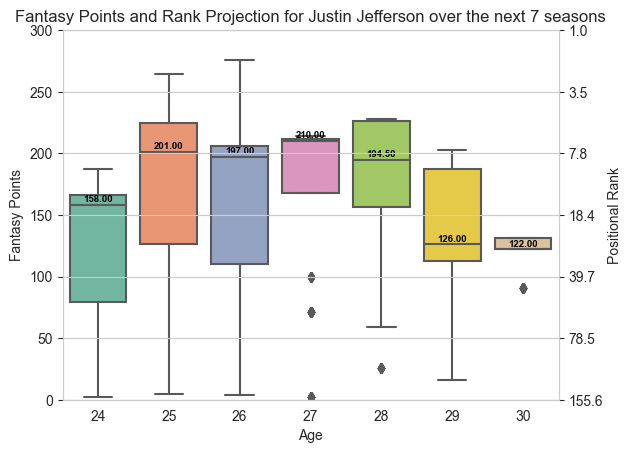

In [78]:
final_output
proj_points = projection_stats(target = target, output = final_output, season_df = season_df)
visualize_projections(proj_points = proj_points, output = final_output)